In [1]:
import pandas as pd
import warnings
import igraph
import leidenalg
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

__Set Parameters for Loading Data + Analysis:__

In [3]:
#set file path of data folder
data_path = '../data/'

#set BC subtype to analyze
#subtype = "HER2+" #options are "HER2+", "ER+", or "TNBC"

#set QC thresholds
nfeature_min = 200
nfeature_max = 2500
ncount_min = 500
percent_mt_max = 10

#set variable feature selection thresholds
n_highvarfeats = 2000
n_labels = 10

__Edit Data Into Correct Formatting__:
    
Data files need to be edited into a readable format before analysis can begin:

1) genes.tsv

In [5]:
#load gene names file
df_genes = pd.read_csv(data_path + 'genes.tsv', sep='\t', header=None, names=['GeneName'])

#create gene ID column
df_genes['GeneID'] = ['Gene_' + str(i) for i in range(len(df_genes))]

#order columns to match scanpy format
df_genes = df_genes[['GeneID', 'GeneName']]

#save to genes.tsv
df_genes.to_csv(data_path + 'genes.tsv', sep='\t', index=False, header=False)

#load tsv file into DataFrame
df = pd.read_csv(data_path + 'genes.tsv', sep='\t', header = None)
#print(df.head())

#read in data
adata = sc.read_10x_mtx(data_path, var_names='gene_symbols', cache=True)
#print(adata)

2) metadata.csv

In [7]:
#load in metadata
metadata = pd.read_csv(data_path + 'metadata.csv')

#create cell_id header for unique cell identifiers
new_headers = ['cell_id'] + list(metadata.columns[1:])

#assign cell_id header to cells
metadata.columns = new_headers
#print(metadata.head())

#save metadata w/header
metadata.to_csv(data_path + 'metadata.csv', index=False)

#merge data + metadata by cell_id
adata.obs = adata.obs.join(metadata.set_index('cell_id'))
#print(adata.obs.head())

__Set AnnData Object for Downstream Analysis:__

In [9]:
#set copy of raw data
adata.raw = adata

__QC and Subsetting:__

In [11]:
#calculate % mitochondrial DNA per sample
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mt'] = adata[:, mito_genes].X.sum(axis=1) / adata.X.sum(axis=1) * 100
#print(adata.obs.head())

In [13]:
#filter samples based on QC metrics
adata = adata[(
    (adata.obs['nFeature_RNA'] > nfeature_min) &
    (adata.obs['nFeature_RNA'] < nfeature_max) &
    (adata.obs['nCount_RNA'] > ncount_min) &
    (adata.obs['percent_mt'] < percent_mt_max)
)]

In [15]:
#set samples to analyze to specified subtype
#adata = adata[adata.obs['subtype'] == subtype]
print('Number of TNBC Samples pass QC:', len(adata[adata.obs['subtype'] == "TNBC"]))
print('Number of HER2+ Samples pass QC:', len(adata[adata.obs['subtype'] == "HER2+"]))
print('Number of ER+ Samples pass QC:', len(adata[adata.obs['subtype'] == "ER+"]))


Number of TNBC Samples pass QC: 28548
Number of HER2+ Samples pass QC: 15281
Number of ER+ Samples pass QC: 22246


__Normalization:__

In [17]:
warnings.simplefilter("ignore", UserWarning)
sc.pp.normalize_total(adata, target_sum=1e6)

__Visualization - Violin Plots:__

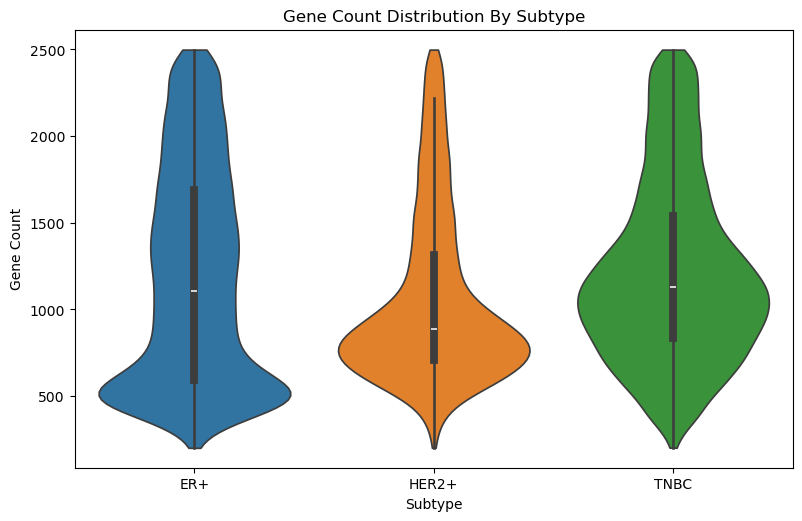

In [19]:
with rc_context({"figure.figsize": (8, 6)}):
    ax = sc.pl.violin(adata, ['nFeature_RNA'], groupby = 'subtype', stripplot = False, show = False, inner = 'box')
    ax.set_title(f'Gene Count Distribution By Subtype')
    ax.set_xlabel('Subtype')
    ax.set_ylabel('Gene Count')

    plt.show()

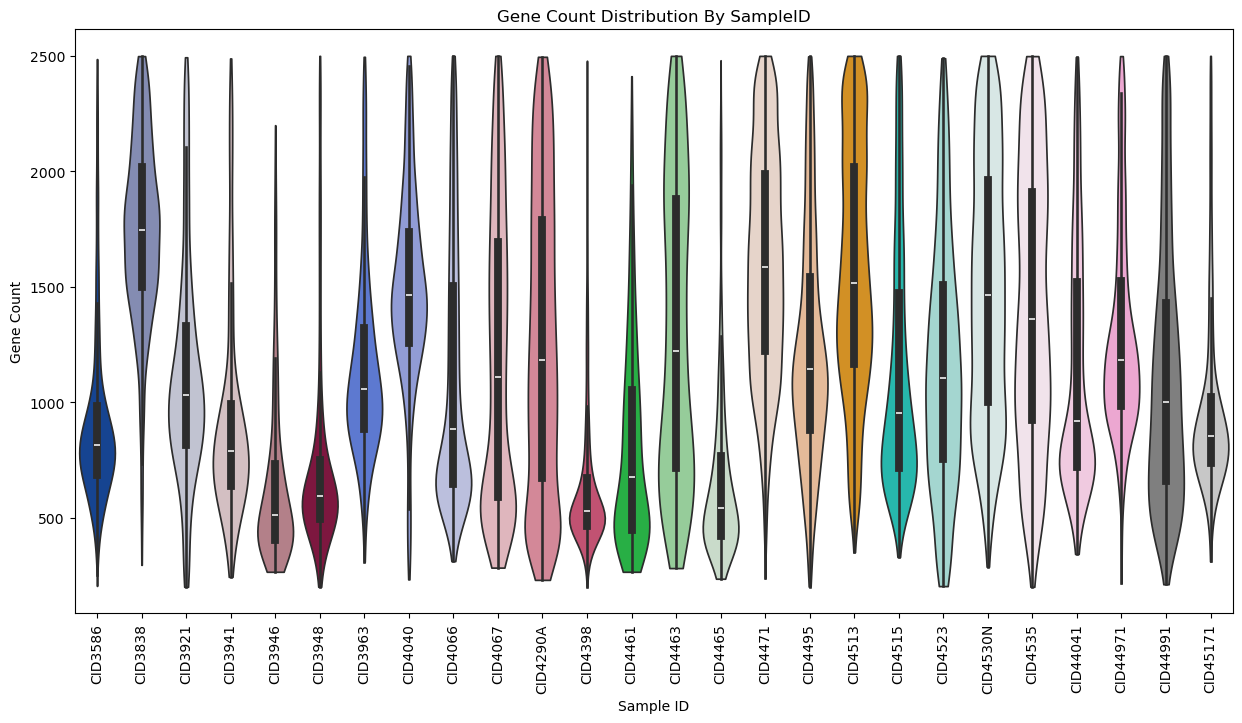

In [21]:
with rc_context({"figure.figsize": (12, 8)}):
    ax = sc.pl.violin(adata, ['nFeature_RNA'], groupby = 'orig.ident', stripplot = False, show = False, rotation = 90, inner = 'box')
    ax.set_title(f'Gene Count Distribution By SampleID')
    ax.set_xlabel('Sample ID')
    ax.set_ylabel('Gene Count')

    plt.show()

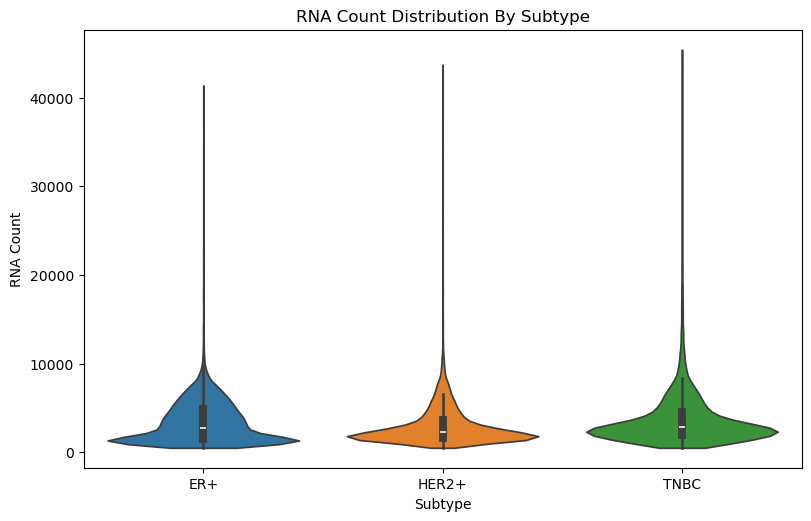

In [23]:
with rc_context({"figure.figsize": (8, 6)}):
    ax = sc.pl.violin(adata, ['nCount_RNA'], stripplot = False, show = False, groupby = 'subtype', inner = 'box')
    ax.set_title(f'RNA Count Distribution By Subtype')
    ax.set_xlabel('Subtype')
    ax.set_ylabel('RNA Count')

    plt.show()

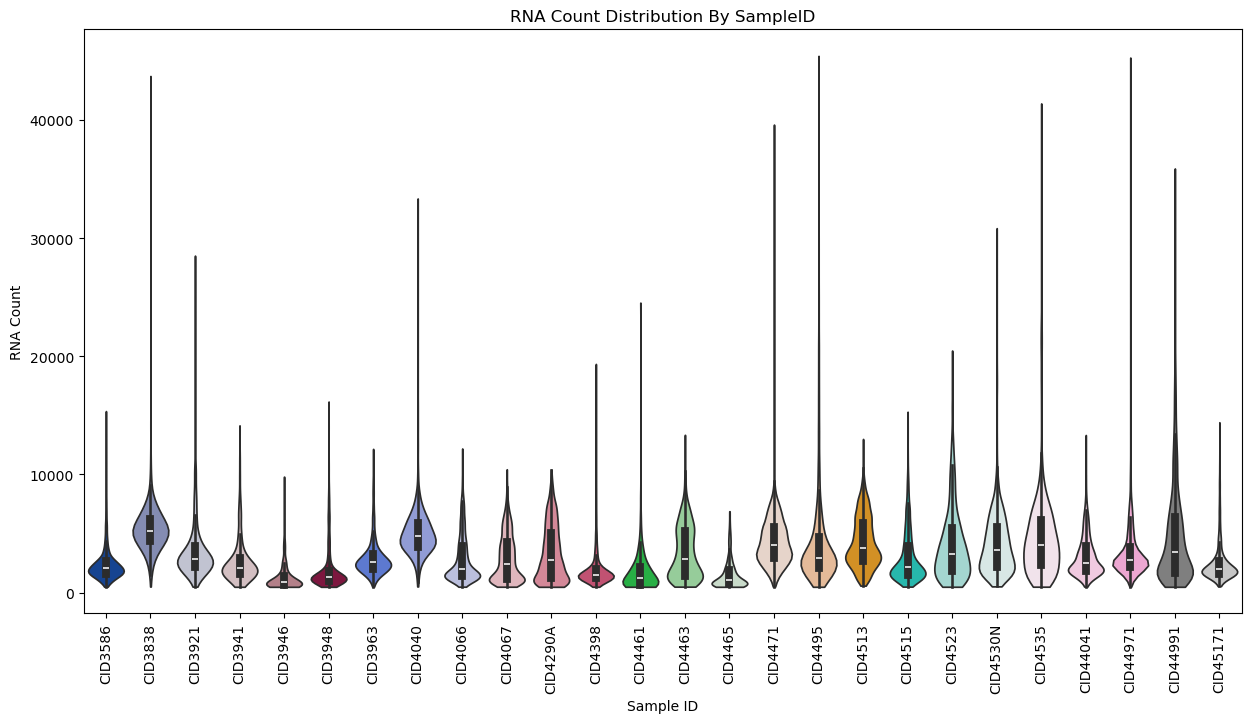

In [25]:
with rc_context({"figure.figsize": (12, 8)}):
    ax = sc.pl.violin(adata, ['nCount_RNA'], groupby = 'orig.ident', stripplot = False, show = False, rotation = 90, inner = 'box')
    ax.set_title(f'RNA Count Distribution By SampleID')
    ax.set_xlabel('Sample ID')
    ax.set_ylabel('RNA Count')

    plt.show()

__Visualization - Scatterplots:__

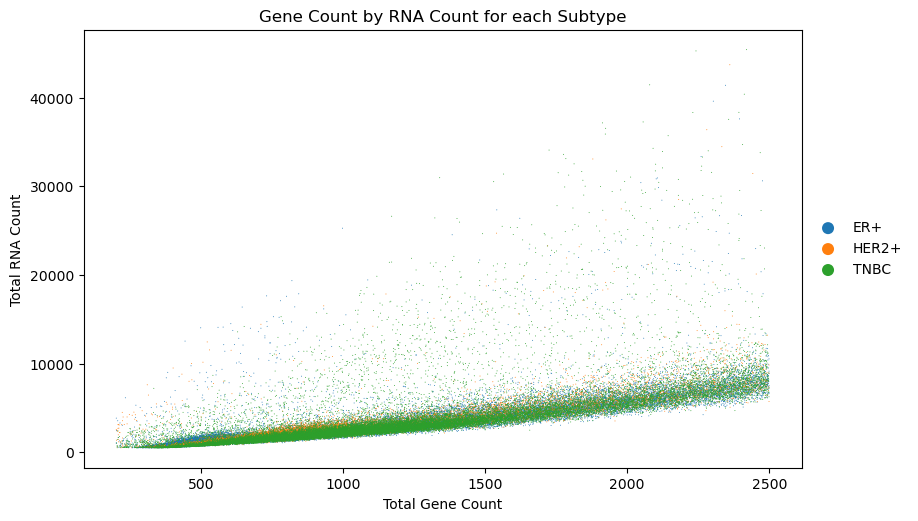

In [27]:
with rc_context({"figure.figsize": (8, 6)}):
    ax = sc.pl.scatter(adata, x='nFeature_RNA', y='nCount_RNA', color = 'subtype', title = f'Gene Count by RNA Count for each Subtype', show = False)
    ax.set_xlabel('Total Gene Count')
    ax.set_ylabel('Total RNA Count')
    plt.show()

__Highly Variable Feature Selection:__

In [29]:
sc.pp.log1p(adata)

In [31]:
sc.pp.highly_variable_genes(adata, n_top_genes=n_highvarfeats, flavor = 'seurat')

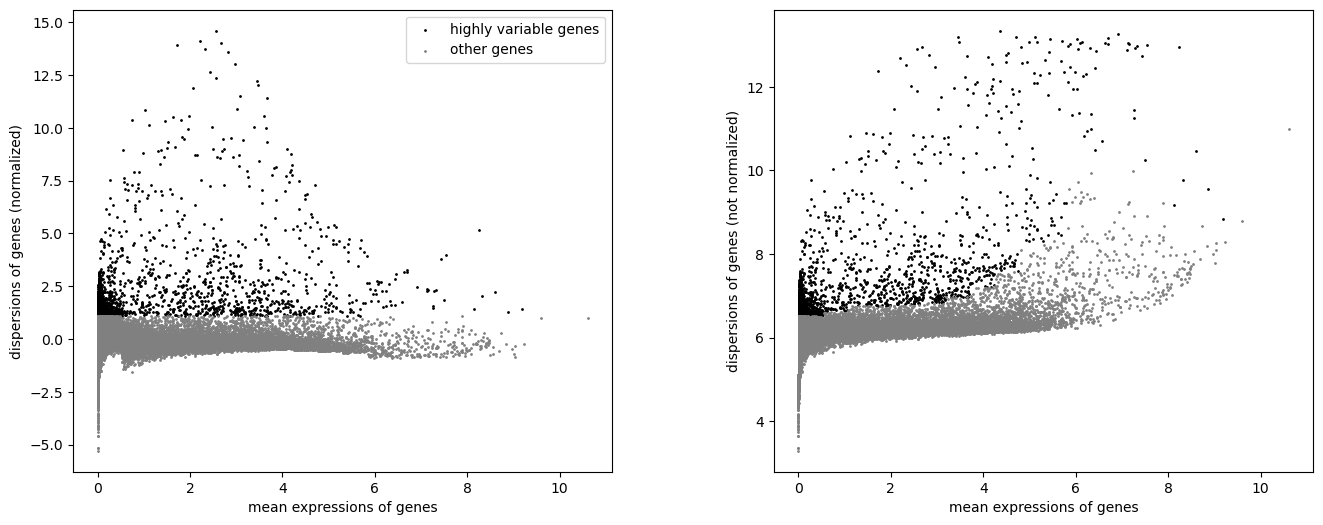

In [33]:
with rc_context({"figure.figsize": (8, 6)}):
    sc.pl.highly_variable_genes(adata, show=True)

In [35]:
top_genes = adata.var[adata.var['highly_variable']]

top_genes_df = pd.DataFrame({'gene': top_genes.index, 'dispersions_norm': adata.var['dispersions_norm'][adata.var['highly_variable']]})
top_genes_df = top_genes_df.sort_values(by='dispersions_norm', ascending = False)

print(top_genes_df.head(20))

                      gene  dispersions_norm
IGHV2-70          IGHV2-70         14.592854
IGKV6-21          IGKV6-21         14.097239
IGKV1D-13        IGKV1D-13         13.991472
IGKV6D-21        IGKV6D-21         13.931277
IGLV7-43          IGLV7-43         13.718511
IGHV3-13          IGHV3-13         13.591035
IGKV1D-17        IGKV1D-17         13.028790
IGLV4-60          IGLV4-60         12.629449
IGKV1D-43        IGKV1D-43         12.357625
IGLV5-45          IGLV5-45         12.234407
IGLV1-36          IGLV1-36         12.020942
IGKV2D-30        IGKV2D-30         11.880206
IGLV9-49          IGLV9-49         11.512489
IGLV10-54        IGLV10-54         11.417071
IGLV1-41          IGLV1-41         10.880379
IGKV5-2            IGKV5-2         10.818738
IGHV1-12          IGHV1-12         10.548870
IGKV2-24          IGKV2-24         10.538364
IGKV1OR2-108  IGKV1OR2-108         10.486162
IGHV3-19          IGHV3-19         10.366118


__Scale Data:__

In [37]:
adata.raw = adata
sc.pp.scale(adata)

__PCA:__

In [41]:
sc.tl.pca(adata, svd_solver='arpack')

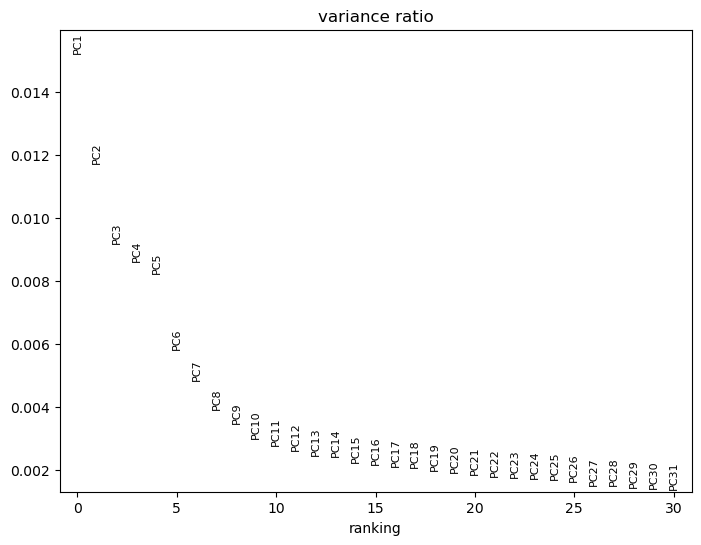

In [43]:
with rc_context({"figure.figsize": (8, 6)}):
    sc.pl.pca_variance_ratio(adata, show = True)

In [45]:
elbow_dims = 9 #set based on number of impactful dims above

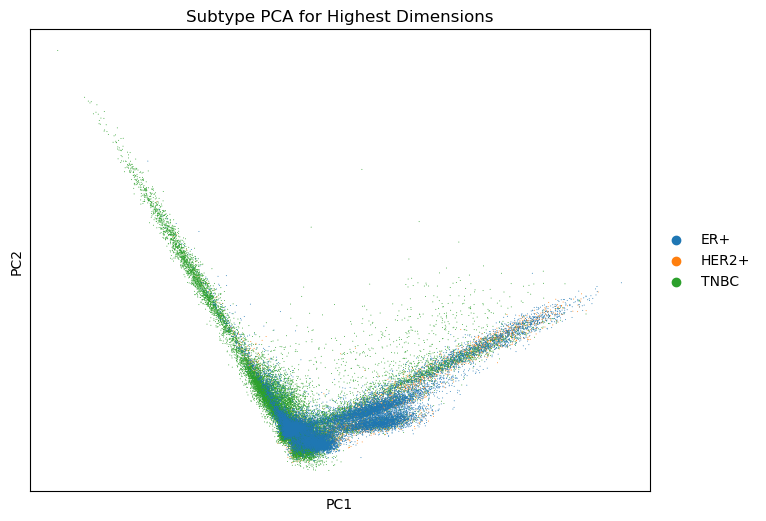

In [61]:
with rc_context({"figure.figsize": (8, 6)}):
    ax = sc.pl.pca(adata, color='subtype', show = False)
    ax.set_title('Subtype PCA for Highest Dimensions')
    plt.show()

__Clustering:__

In [49]:
sc.pp.neighbors(adata, n_pcs=elbow_dims)

In [51]:
sc.tl.leiden(adata, resolution=0.5, flavor = 'igraph', n_iterations = 2)

In [53]:
sc.tl.umap(adata)

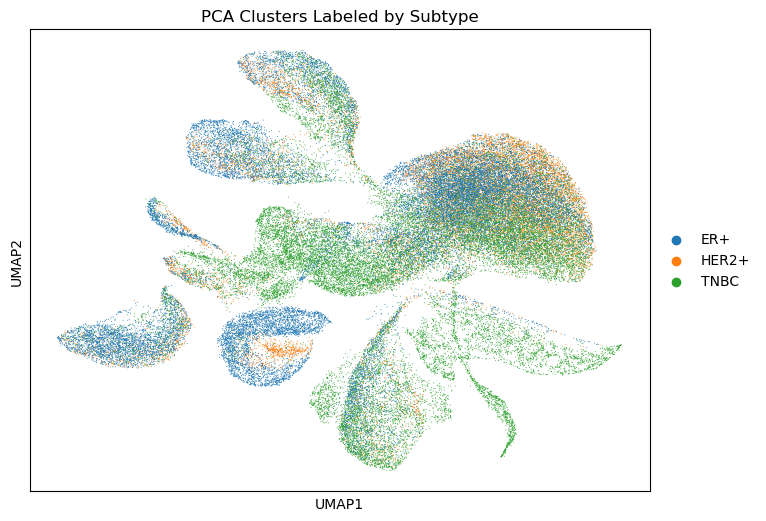

In [65]:
with rc_context({"figure.figsize": (8, 6)}):
    ax = sc.pl.umap(adata, color=['subtype'], show = False)
    ax.set_title('PCA Clusters Labeled by Subtype')
    plt.show()

__Marker Selection:__

In [73]:
sc.tl.rank_genes_groups(adata, groupby = 'leiden', method='t-test')

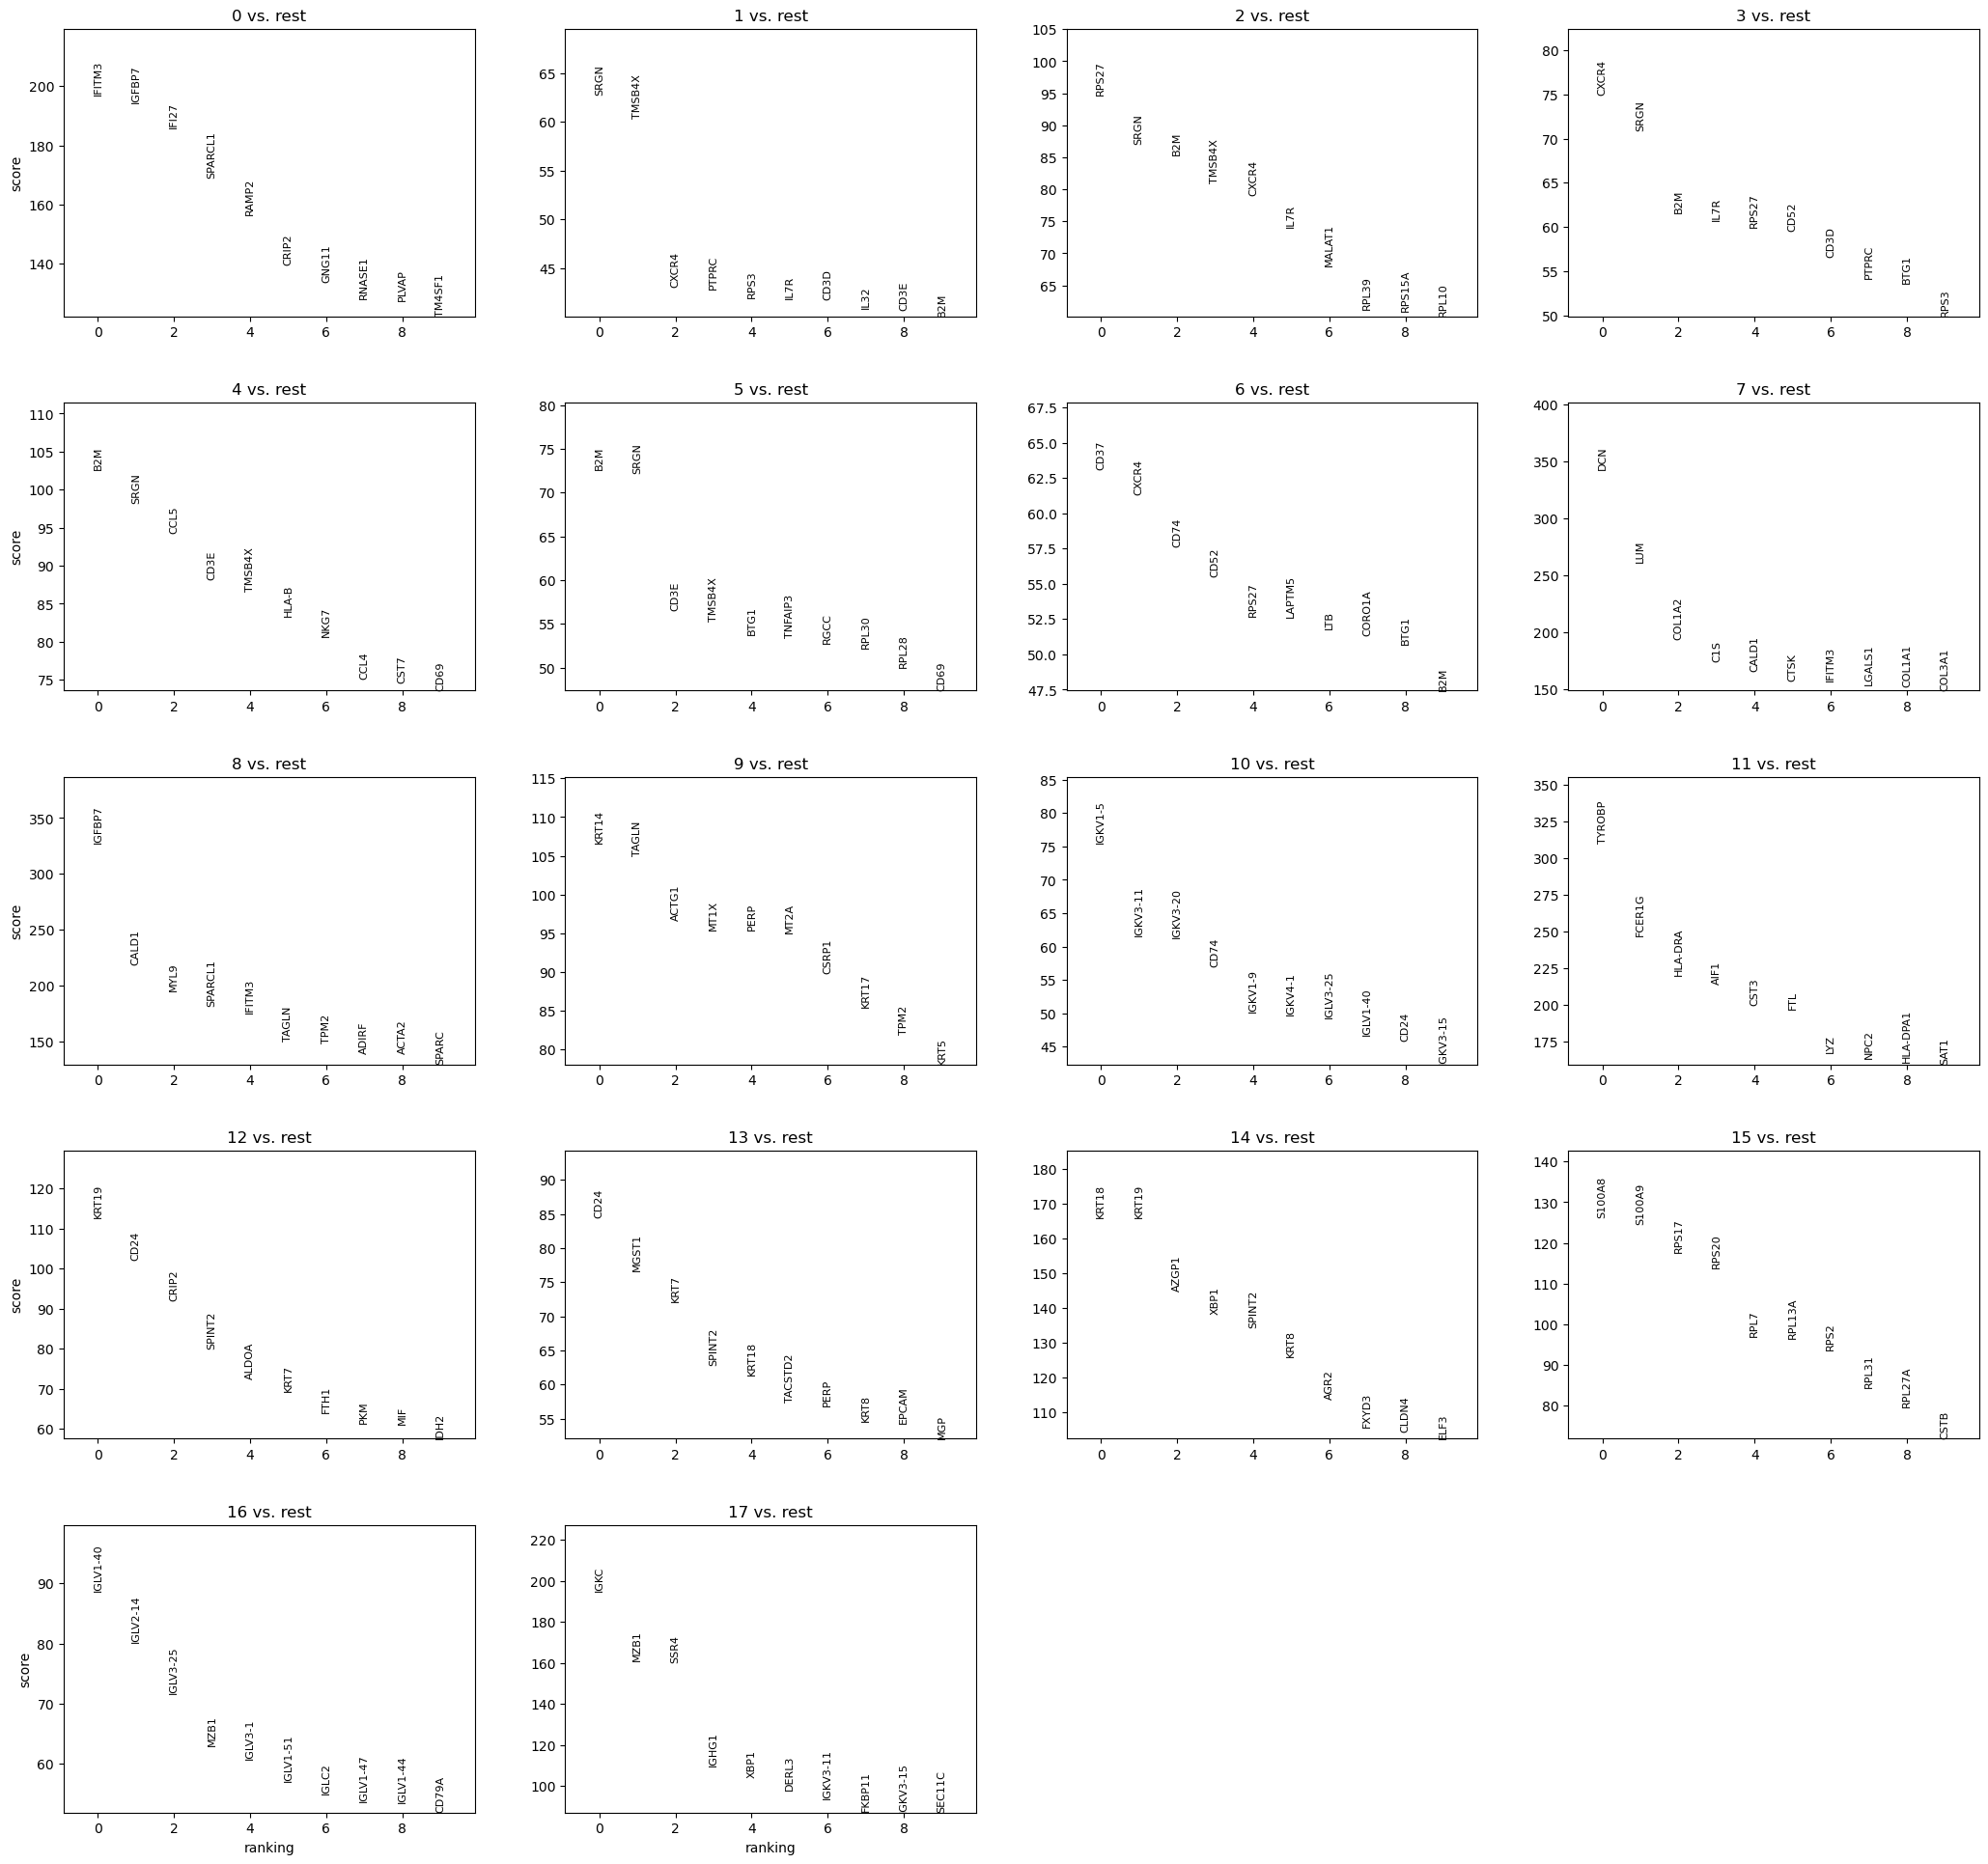

In [109]:
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [181]:
cell_types = {
    '0': 'Lysosomes',
    '1': 'Endothelia',
    '2': 'Macrophages',
    '3': 'Treg Cells',
    '4': 'MSCs',
    '5': 'Fibroblasts',
    '6': 'Mature B Cells',
    '7': 'ECM Proteins',
    '8': 'Smooth Muscle Cells',
    '9': 'Myoepithelial Cells',
    '10': 'T Cells',
    '11': 'Microglia',
    '12': 'Epicardial Cells',
    '13': 'Epithelial Cells',
    '14': 'Blastocysts',
    '15': 'Myeloid Cells',
    '16': 'B Lymphocytes',
    '17': 'Plasma Cells',
}

In [183]:
adata.obs['cell_type'] = adata.obs['leiden'].map(cell_types)

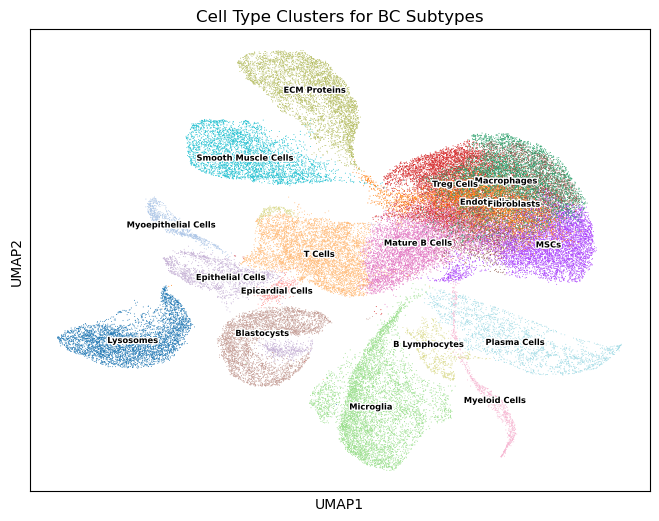

In [185]:
with rc_context({"figure.figsize": (8, 6)}):
    sc.pl.umap(adata, color='cell_type', title = 'Cell Type Clusters for BC Subtypes', legend_loc = 'on data', legend_fontsize=6, legend_fontoutline=2)